# ${\textbf{Customer Analytics - Segmentation}}$

## ${\textbf{Dataset Information}}$


We've got a data set that consists of information about 2000 individuals from a given area. The information contained comes from the purchasing behavior of these 2000 individuals when entering a physical FMC store, all data has been collected through the loyalty cards they use at checkout. For this course, we have pre-process the data, encoded all variables numerically and dealt with missing values, and restricted the volume of the data set and protected the privacy of the customers.


> **TIP**: It's good practice to start by manually exploring the data set, for example, opening data sets for the first time in Excel.

## ${\textbf{Libraries}}$

In [1]:
import numpy as np
import pandas as pd
import scipy
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## ${\textbf{Import Data}}$

In [2]:
df_segmentation = pd.read_csv("DATA/segmentation data.csv", index_col=0)
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


## ${\textbf{Explore Data}}$

In [3]:
# Descriptive analysis of the data
df_segmentation.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Sex,2000.0,0.4570,0.498272,0.0,0.00,0.0,1.00,1.0
Marital status,2000.0,0.4965,0.500113,0.0,0.00,0.0,1.00,1.0
Age,2000.0,35.9090,11.719402,18.0,27.00,33.0,42.00,76.0
Education,2000.0,1.0380,0.599780,0.0,1.00,1.0,1.00,3.0
Income,2000.0,120954.4190,38108.824679,35832.0,97663.25,115548.5,138072.25,309364.0
Occupation,2000.0,0.8105,0.638587,0.0,0.00,1.0,1.00,2.0
Settlement size,2000.0,0.7390,0.812533,0.0,0.00,1.0,1.00,2.0


## ${\textbf{Correlation Estimate}}$

A good way to get an initial understanding of the relationships between the different variables is to explore how they correlate. Depending on the types of data, you can employ different techniques to quantify this correlation.

Pearson's correlation **describes the linear dependency between variables**, it ranges from [-1 to +1], with +1 indicating very strong positive correlation, -1 strong negative correlation, and 0 means that the two variables are not linearly dependent.

In [4]:
df_segmentation.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


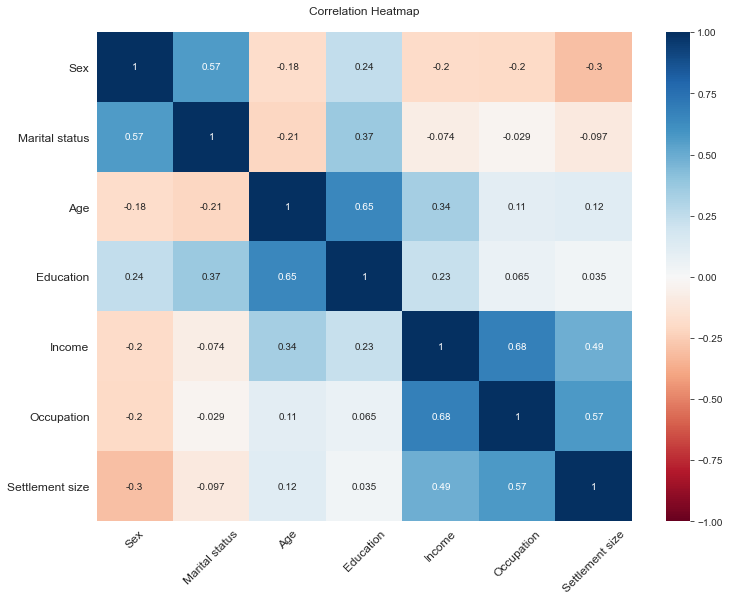

In [5]:
plt.figure(figsize = (12, 9))

s = sns.heatmap(df_segmentation.corr(),
               annot = True, 
               cmap  = 'RdBu',
               vmin  = -1, 
               vmax  = 1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 45, fontsize = 12)
plt.title('Correlation Heatmap\n')
plt.show()

With this heat map, we can actually see:
- strong positive correlation between age and education
- strong positive correlation between occupation and income
- positive correlation between occupation and settlement size.

These are the kinds of relationships we'll be looking for to use for segmentation purposes. Exploring the correlations between the features of the consumers is the first step to **identifying similar consumers and putting them together in groups, which is the essence of segmentation**.

## ${\textbf{Visualize Raw Data}}$

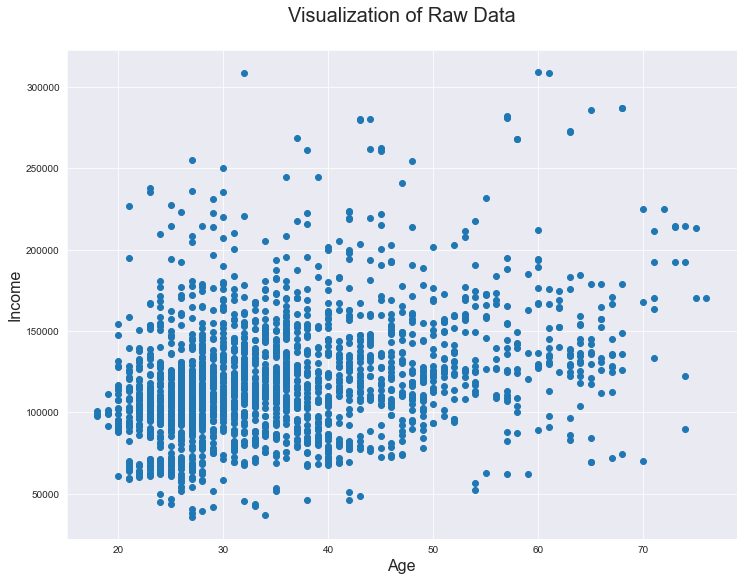

In [6]:
plt.figure(figsize = (12, 9))

# Age vs Income
plt.scatter(df_segmentation.iloc[:, 2], df_segmentation.iloc[:, 4])
plt.xlabel('Age', fontsize=16)
plt.ylabel('Income', fontsize=16)
plt.title('Visualization of Raw Data\n', fontsize=20)
plt.show()

## ${\textbf{Standardization}}$

**Why standardization is so crucial?**

Our segmentation models will be based on similarities and differences between individual consumers, on the features that characterize them. We'll quantify these similarities and differences. Possible differences inside the data set:
- *Age*: imagine two individual consumers, one may be 20 year old, while another 70 years old, so the difference in age is 50 years.
- *Income*: imagine two individual consumers, one may have an annual income of 100.000 dollars and the second individual may have an annual income of 150.000 dollars. Therefore, the difference between their incomes will be 50.000 dollars.

If these numbers go into any of our segmentation models as they are, the algorithms will believe that the two differ in terms of one variable by 50, while in terms of another by 50000. Then because of the mathematical nature of modeling, it would **completely disregard age as a feature because the numbers from 20 to 70 are insignificant when compared with the income values around 100000**.

This happends because the model is not familiar with our context, which defines one is age while the other is income. Therefore, **it will place a much bigger weight on the income variable**. It is obvious that we must protect ourselves from such an outcome known as bias.


What's more, in general, we want to **treat all the features equally** and we can achieve that by **transforming the features in such a way that their values fall within the same numerical range**. Thus, the differences between their values will be comparable. This transformation process is known as *standardization*.

In [7]:
# Standardizing data, so all features have equal weight, very important for modelling
# Otherwise, in our case Income would be considered much more important than Education for Instance. 
# We do not know if this is the case, so we would not like to introduce it to our model. 
# This is what is also refered to as bias.
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

In [8]:
segmentation_std

array([[-0.91739884, -0.99302433,  2.65361447, ...,  0.09752361,
         0.29682303,  1.552326  ],
       [ 1.09003844,  1.00702467, -1.18713209, ...,  0.78265438,
         0.29682303,  1.552326  ],
       [-0.91739884, -0.99302433,  1.11731585, ..., -0.83320224,
        -1.26952539, -0.90972951],
       ...,
       [-0.91739884, -0.99302433, -0.41898277, ..., -0.90695688,
        -1.26952539, -0.90972951],
       [ 1.09003844,  1.00702467, -1.01643224, ..., -0.60332923,
        -1.26952539, -0.90972951],
       [-0.91739884, -0.99302433, -0.93108232, ..., -1.3789866 ,
        -1.26952539, -0.90972951]])

## ${\textbf{Hierarchical Clustering}}$

The main goal of clustering is to group individual observations so that the observations from one group are very similar to each other, and in addition, we'd like them to be very different from the observations in other groups.

There are two broad types of clustering, hierarchical and flat.

- **Hierarchical Clustering**: An example of clustering with hierarchy is the taxonomy of the animal kingdom. Now there are two types of hierarchical clustering, divisive or top down agglomerated or bottom up with divisive clustering. 
    - *Divisive or Top Down*: We start from a situation where all observations are in the same cluster, like the animal kingdom. Then we split this big cluster into two smaller ones. After that, we can split one of them into two more, making the total number of clusters. We can continue in this manner until each observation is its separate cluster. However, in order to find the best split, we must explore all possibilities at each step.
    - *Agglomerated or Bottom Up*: We start from different kangaroo and koala species, cluster them into kangaroos and koalas respectively, and then we continue pairing up groups of species until we reach the animal cluster. 
    - Agglomerated and divisive clustering should reach similar results, but agglomerate is much easier to solve mathematically.
    - This is why agglomerated hierarchical clustering is the preferred option if we decide to implement it in practice.


**How do we measure the distances between observations?**

Well, there are different measures we can use. There's the Euclidean distance, the Manhattan distance or maximum distance, etc. So, we have multiple options of distances that can be used for segmentation problems.

By far, the most widely used method is the **Ward Method, which calculates the average of the squares of the distances between clusters**.

$$\textit{Ward Distance} = \frac{||A - B||^2}{n_{scale}}$$

$$$$

Hierarchical clustering is one of the most common clustering methods, we will discuss it in the context of segmentation and customer analytics. 

We can use Python to elaborate a hierarchical clustering, using a dendogram and linkage from scipy module.

A dendogram is a tree like hierarchical representation of points, it provides a nice visual and it's **the main tool that is used to assess a hierarchical clustering solution**. Linkage, on the other hand, refers to the specific clustering methods we employ.

In [9]:
# Perform Hierarchical Clustering, results are returned as linkage matrix. 
hier_clust = linkage(segmentation_std, method='ward')

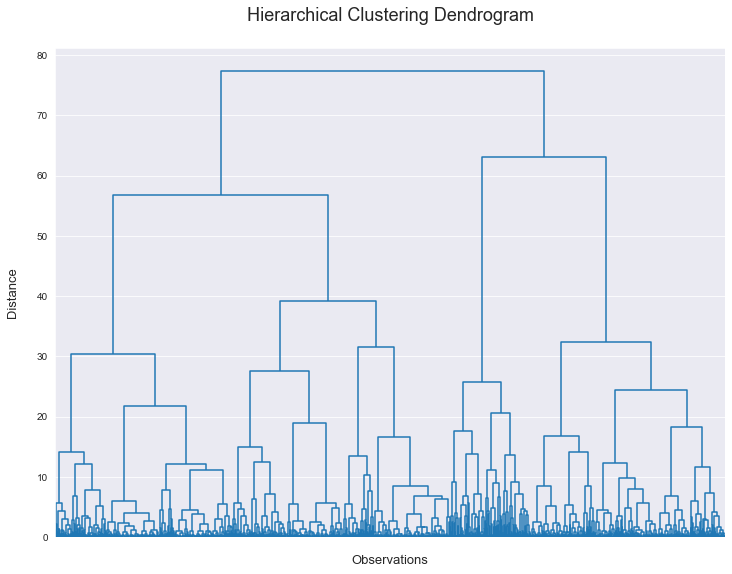

In [10]:
plt.figure(figsize = (12,9))

plt.title('Hierarchical Clustering Dendrogram\n', fontsize=18)
plt.xlabel('\nObservations', fontsize=13)
plt.ylabel('Distance\n', fontsize=13)

dendrogram(hier_clust,
           show_leaf_counts = False, 
           no_labels = True,
           color_threshold=0)  # color_threshold=0 hides the clusters by color
plt.show()

These are 2000 individual points. The goal of our clustering algorithm is to group them together based on their distance. The distance is the Y axis, therefore, distances between points are represented by the vertical lines. So, the smaller the distance between points, the further down and the tree, they'll be grouped together, this also shows that they are more similar to one another.

Because we have all 2000 observations plotted, the dendogram looks a bit crowded, let's truncated a bit. We'll set `truncate_mode='level'`, and set the level `p=5`. This means that we will will only see the last five merge cluster levels.

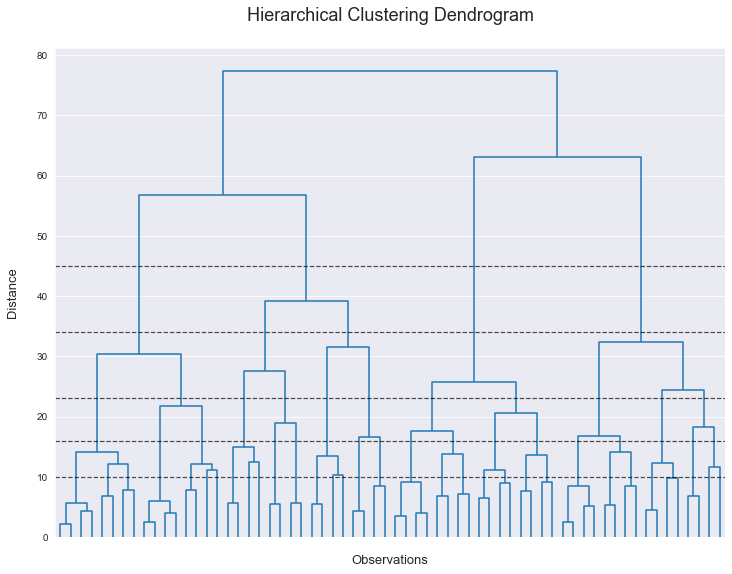

In [33]:
plt.figure(figsize = (12,9))

plt.title('Hierarchical Clustering Dendrogram\n', fontsize=18)
plt.xlabel('\nObservations', fontsize=13)
plt.ylabel('Distance\n', fontsize=13)
plt.axhline(y=45, **{'alpha':0.7, 'c': 'black', 'ls': '--', 'lw': 1.2})
plt.axhline(y=34, **{'alpha':0.7, 'c': 'black', 'ls': '--', 'lw': 1.2})
plt.axhline(y=23, **{'alpha':0.7, 'c': 'black', 'ls': '--', 'lw': 1.2})
plt.axhline(y=16, **{'alpha':0.7, 'c': 'black', 'ls': '--', 'lw': 1.2})
plt.axhline(y=10, **{'alpha':0.7, 'c': 'black', 'ls': '--', 'lw': 1.2})

dendrogram(hier_clust,
           truncate_mode = 'level', 
           p = 5, 
           show_leaf_counts = False, 
           no_labels = True,
           color_threshold=0)
plt.show()

Now we come to the most important part of clustering, finding amount of clusters. 

**How do we find the amount of clusters?**

*Answer*: We need to find a horizontal line in the den diagram on which to cut.

This means that under this line, every vertical line will signal the beginning of a cluster. All the leaves which are connected to the line until the cut will belong to a separate cluster. Obviously, we can cut the program in many different places. 

**So how do we choose where to make the cut in the dendogram?**

*Answer*: Well, there is a rule of thumb which can be quite useful. We find the longest vertical line which isn't intercepted by a horizontal line from the tender ground. This is where we should make the cut.

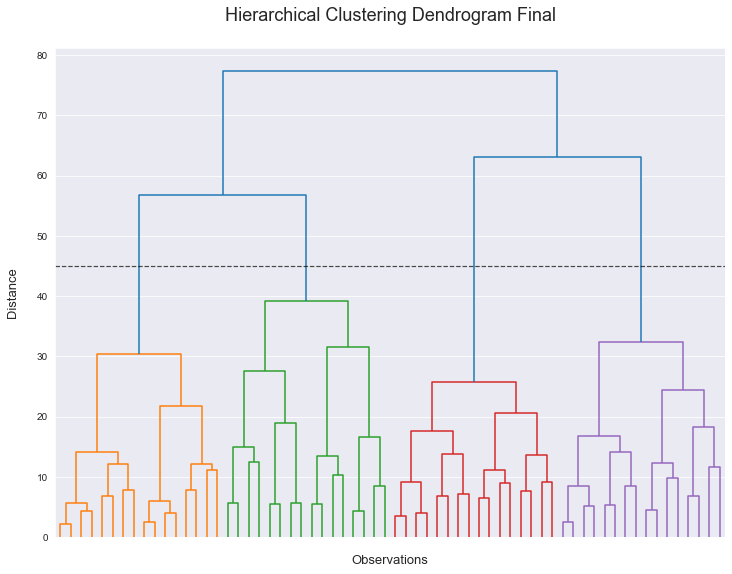

In [12]:
plt.figure(figsize = (12,9))

plt.title('Hierarchical Clustering Dendrogram Final\n', fontsize=18)
plt.xlabel('\nObservations', fontsize=13)
plt.ylabel('Distance\n', fontsize=13)
plt.axhline(y=45, **{'alpha':0.7, 'c': 'black', 'ls': '--', 'lw': 1.2})

dendrogram(hier_clust,
           truncate_mode='level', 
           p=5, 
           show_leaf_counts=False, 
           no_labels=True)
plt.show()

That's also how we usually go about a hierarchical clustering solution. Now, we only have 2000 observations, however, with bigger datasets, a **hierarchical clustering solution may take minutes or hours to compute, precisely because it is slow. This is not very practical, but it has one major advantage over other methods, it finds the number of clusters in the data**.

Usually in practice, we employ **flat clustering techniques rather than hierarchical their way faster**. 

But **if we have no prior knowledge about the number of clusters, we can start by performing hierarchical clustering** to determine them, then we can employ flat clustering for the segmentation itself.

## ${\textbf{K-means Clustering}}$

K-Means is one of the most commonly used methods in clustering, the reason for that is because of its simplicity, here's how it works:

1. First, we must choose how many clusters we'd like to have, the K in K-means stands for the number of clusters we're trying to identify.
2. The second step is to specify the cluster seeds. A seed is basically a starting centroid. The centroid is chosen at random or specified by the user based on prior knowledge about the data.
3. The next step is to assign each point on the graph to a seed which is done based on proximity. In this way, we can assign all points on the graph to a cluster based on their Euclidean square distance.
4. The final step is to calculate the centroid or the geometrical center of the clusters.


**Due to its simplicity, K Means is prone to some issues**:

- First, the squared Euclidean distance is quite sensitive to outliers, usually points that are too far away from the rest will always become a cluster of their own. To overcome this, we can **perform the so-called K medium clustering**. However, it is more computationally expensive.


- Second disadvantage arises from the fact that in K means we have to specify the number of clusters before starting.This is an issue that a lot of the clustering algorithm share in the case of K means if we choose: 
    - K too small: the centroid will not lie inside the clusters, clearly not representative of the data.
    - K too large: some of the clusters may be split into two.
    
    
    
- The third important issue is that K means enforces clusters which are of spherical shape or blobs. The reason is that we are trying to minimize the distance from the centroid in a straight line. So if we have clusters which are more elongated, K means will have difficulty separating them. Turns out that for segmentation, K-Means usually yields good results, which is great because this is what we'll be using it for. We often find the population segments have spherical or somewhat similar to that shape.



In [13]:
# Perform K-means clustering, considering 1 - 10 clusters.
# In addition we run the algortihm at many different starting points (kmeans++). 

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

$$$$

**How exactly do we choose how many clusters?**

We'll use an approach known as the elbow method. This graph looks like an arm with an elbow. **The goal here is to spot the elbow itself and take that many clusters**. Usually the part of the graph below the elbow would be steeply declining, while the part after it much smoother.

$$$$

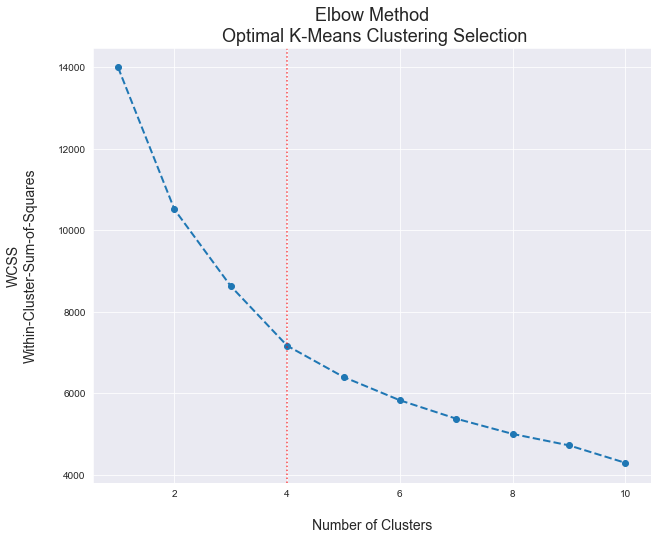

In [14]:
plt.figure(figsize = (10,8))

plt.plot(range(1, 11), wcss, marker='o', linestyle='--', lw=2)
plt.xlabel('\nNumber of Clusters', fontsize=14)
plt.ylabel('WCSS\nWithin-Cluster-Sum-of-Squares\n', fontsize=14)
plt.title('Elbow Method\n Optimal K-Means Clustering Selection', fontsize=18)
plt.axvline(x=4, **{'alpha':0.7, 'c': 'red', 'ls': ':', 'lw': 1.5})

plt.show()

In [15]:
# k-means with k=4
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

# divide data into 4 clusters
kmeans.fit(segmentation_std)

KMeans(n_clusters=4, random_state=42)

### ${\textbf{Results}}$

In [16]:
# Make copy of df and add the kmeans labels as a column
df_segm_kmeans = df_segmentation.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_
df_segm_kmeans.tail()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means
ID,,,,,,,,
100001996,1,0,47,1,123525,0,0,1
100001997,1,1,27,1,117744,1,0,2
100001998,0,0,31,0,86400,0,0,1
100001999,1,1,24,1,97968,0,0,2
100002000,0,0,25,0,68416,0,0,1


In [17]:
# Estimate mean values for each cluster
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695
3,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807


In [19]:
# Calculate the size and proportions of each cluster
df_segm_analysis['Num Obs'] = df_segm_kmeans[['Segment K-means', 'Sex']] \
                            .groupby(['Segment K-means']).count()

df_segm_analysis['Prop Obs'] = df_segm_analysis['Num Obs'] \
                            / df_segm_analysis['Num Obs'].sum()

In [20]:
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Num Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
3,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850


In [21]:
# Name the groups based on their characteristics (look table above)
df_segm_analysis.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'standard',
                         3:'career focused'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Num Obs,Prop Obs
Segment K-means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
career focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850


In [22]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'] \
                                .map({0:'well-off',
                                      1:'fewer opportunities',
                                      2:'standard',
                                      3:'career focused'})

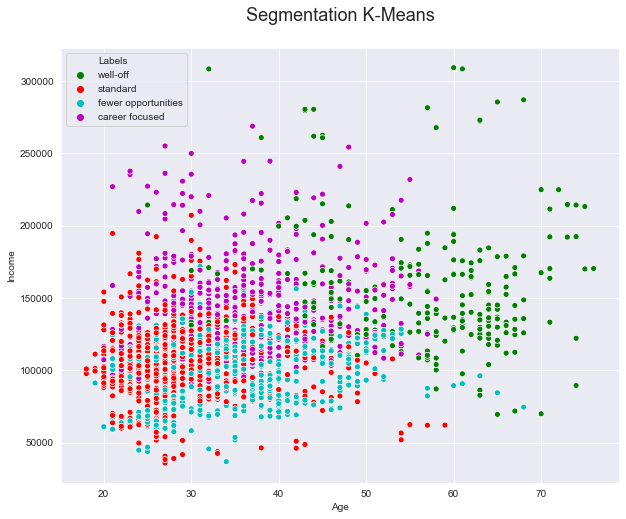

In [25]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x='Age', y='Income', hue='Labels', data=df_segm_kmeans,
                palette=['g', 'r', 'c', 'm'])
plt.title('Segmentation K-Means\n', fontsize=18)
plt.show()

We can see the green segment well-off is clearly separated as it is highest in both *'Age'* and *'Income'*. Unfortunately, the other three clusters are grouped together, so it's harder to get more insight just by looking at this plot.

We can conclude that K-Means did a decent job at separating our data into clusters, however, the result is far from perfect, we're interested to see how we can get even more out of it, so we'll combine K-Means with PCA (principal component analysis) and try to get a better result.

### ${\textbf{PCA}}$

**What is dimensionality reduction?**

Using linear algebraic operations, allow us to transform a three dimensional dataset into a two dimensional dataset. Of course, some information is lost, but the total number of features is reduced in this way. Instead of having three variables, we reduce the problem to have only two variables. In fact, if you have 50 variables, you can reduce them to 40 or 20 or even 10. And that's where dimensionality reduction has the biggest impact. We will focus on a dimensionality reduction method called Principal Component Analysis (PCA).

In [34]:
# Employ PCA to find a subset of components, which explain the variance in the data
pca = PCA()

In [35]:
# Fit PCA with the standardized data
pca.fit(segmentation_std)

PCA()

In [36]:
# The attribute shows how much variance is explained by each of the 7 components
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

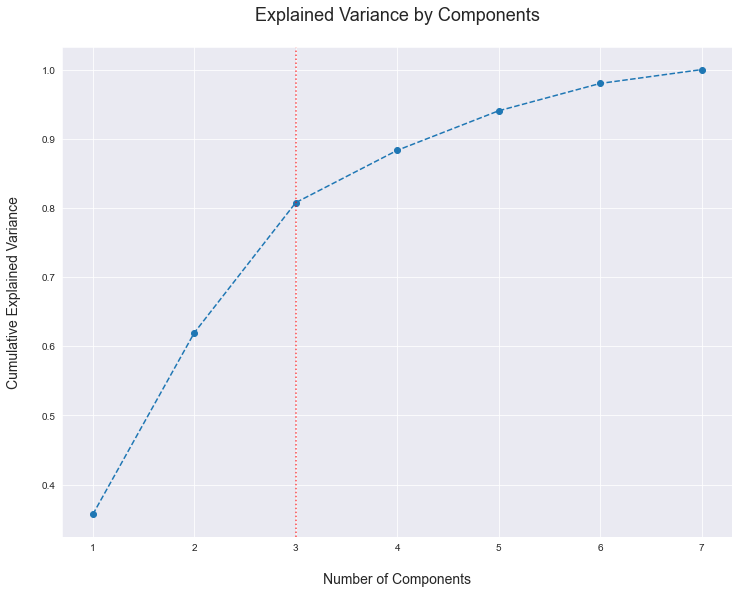

In [38]:
# Plot the cumulative variance explained by total number of components.
# On this graph we choose the subset of components we want to keep. 
# Generally, we want to keep around 80 % of the explained variance.
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components\n', fontsize=18)
plt.xlabel('\nNumber of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance\n', fontsize=14)
plt.axvline(x=3, **{'alpha':0.7, 'c': 'red', 'ls': ':', 'lw': 1.5})

plt.show()

In [39]:
# Choose 3 or 4 components
pca = PCA(n_components=3)

# Fit the model
pca.fit(segmentation_std)

PCA(n_components=3)

### ${\textbf{PCA Results}}$

In [40]:
# The components attribute shows the loadings of each component on each of the 7 original features
# The loadings are the correlations between the components and the original features
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [41]:
df_pca_comp = pd.DataFrame(data=pca.components_,
                           columns=df_segmentation.columns.values,
                           index=['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


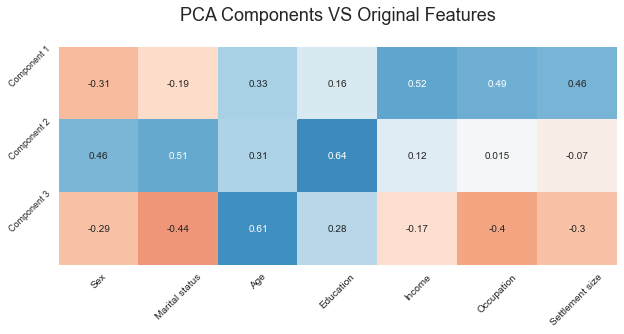

In [51]:
# Heat Map for Principal Components against original features
plt.figure(figsize=(10,4))

sns.heatmap(df_pca_comp,
            vmin=-1, 
            vmax=1,
            cmap='RdBu',
            cbar=False,
            annot=True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation=45,
           fontsize=9)
plt.xticks(rotation=45)
plt.title("PCA Components VS Original Features\n", fontsize=18)

plt.show()

In [52]:
pca.transform(segmentation_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [54]:
scores_pca = pca.transform(segmentation_std)
scores_pca

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

### ${\textbf{K-means clustering with PCA}}$

In [56]:
# Fit K means using the transformed data from the PCA
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

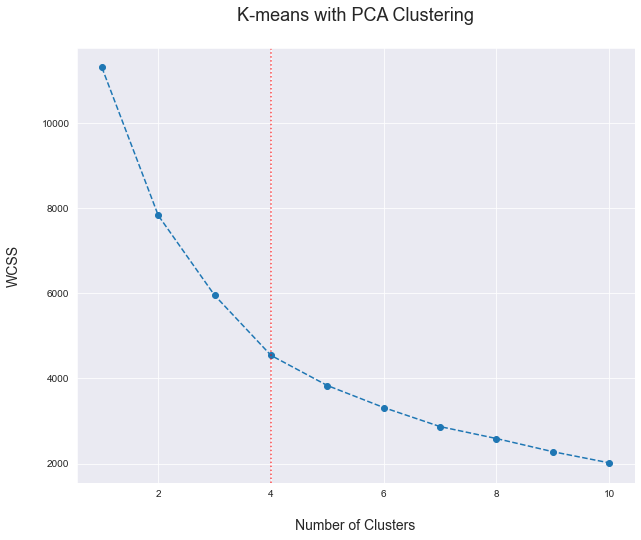

In [57]:
# Plot the Within Cluster Sum of Squares for the K-means PCA model
plt.figure(figsize=(10,8))

plt.plot(range(1, 11), wcss, marker= 'o', linestyle='--')
plt.xlabel('\nNumber of Clusters', fontsize=14)
plt.ylabel('WCSS\n', fontsize=14)
plt.title('K-means with PCA Clustering\n', fontsize=18)
plt.axvline(x=4, **{'alpha':0.7, 'c': 'red', 'ls': ':', 'lw': 1.5})

plt.show()

In [65]:
# Fit K-means with 4 clusters 
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

# New df with original features plus the PCA scores and assigned clusters
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), \
                                pd.DataFrame(scores_pca)], \
                                axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']

# Add the pca k-means clustering labels
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [66]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,2
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,0
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,2
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,0


In [68]:
# Calculate the means by segments
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq.T

Segment K-means PCA,0,1,2,3
Sex,0.900289,0.027444,0.306522,0.505660
Marital status,0.965318,0.168096,0.095652,0.690566
Age,28.878613,35.737564,35.313043,55.679245
Education,1.060694,0.734134,0.760870,2.128302
Income,107551.500000,141525.826758,93692.567391,158019.101887
Occupation,0.677746,1.267581,0.252174,1.120755
Settlement size,0.440751,1.480274,0.039130,1.101887
Component 1,-1.107019,1.372663,-1.046406,1.687328
Component 2,0.703776,-1.046172,-0.902963,2.031200
Component 3,-0.781410,-0.248046,1.003644,0.844039


In [70]:
# Calculate the size of each cluster and its proportion to the entire data set.
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})
df_segm_pca_kmeans_freq.T

Segment K-means PCA,standard,career focused,fewer opportunities,well-off
Sex,0.900289,0.027444,0.306522,0.505660
Marital status,0.965318,0.168096,0.095652,0.690566
Age,28.878613,35.737564,35.313043,55.679245
Education,1.060694,0.734134,0.760870,2.128302
Income,107551.500000,141525.826758,93692.567391,158019.101887
Occupation,0.677746,1.267581,0.252174,1.120755
Settlement size,0.440751,1.480274,0.039130,1.101887
Component 1,-1.107019,1.372663,-1.046406,1.687328
Component 2,0.703776,-1.046172,-0.902963,2.031200
Component 3,-0.781410,-0.248046,1.003644,0.844039


In [71]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})

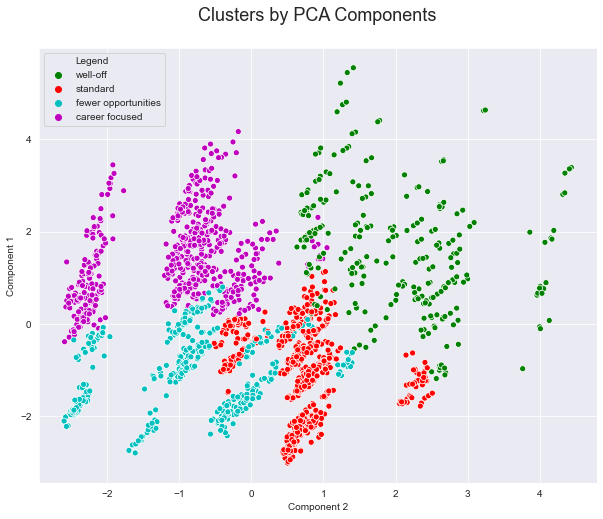

In [73]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'],
                palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components\n', fontsize=18)
plt.show()

### ${\textbf{Data Export}}$

In [75]:
# We save the objects and export them as pickle files
# We need the scaler, pca and kmeans_pca objects
pickle.dump(scaler, open('00-scaler.pickle', 'wb'))

In [76]:
pickle.dump(pca, open('01-pca.pickle', 'wb'))

In [77]:
pickle.dump(kmeans_pca, open('02-kmeans_pca.pickle', 'wb'))